In [413]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import statsmodels.api as sm
%matplotlib inline 

## Tarefa 1

In [414]:
def calc_uncertainty(value, decimal_places=4):
    percent_error = value * 0.002  # 0.2% of reading
    digit_error = 5 * (10**(-decimal_places))  # 5 digits of last decimal place
    return percent_error + digit_error


In [415]:
dados = pd.read_csv(
    "tarefa1.csv"
)  # Corrente(A),Torque(Nm), Incerteza Corrente(A), Incerteza Torque(Nm)
print(dados)
y = dados["tensao campo (V)"]*1000
x = dados["diferença de potencial"]
incy = calc_uncertainty(dados["tensao campo (V)"])*1000
incx = calc_uncertainty(dados["diferença de potencial"], decimal_places=1)

# Format and print x with uncertainties
for xi, incxi in zip(x, incx):
    print(f"{xi} +- {incxi}")


print("")
# Format and print y with uncertainties
for yi, incyi in zip(y, incy):
    print(f"{yi} +- {incyi}")


   tensao campo (V)  diferença de potencial
0              0.24                    25.3
1              0.48                    50.6
2              0.72                    75.6
3              0.95                    99.9
4              1.20                   125.6
5              1.43                   150.3
6              1.67                   175.0
7              1.91                   200.5
8              2.15                   225.3
9              2.39                   250.7
25.3 +- 0.5506
50.6 +- 0.6012
75.6 +- 0.6512
99.9 +- 0.6998
125.6 +- 0.7512
150.3 +- 0.8006
175.0 +- 0.8500000000000001
200.5 +- 0.901
225.3 +- 0.9506000000000001
250.7 +- 1.0013999999999998

240.0 +- 0.98
480.0 +- 1.46
720.0 +- 1.94
950.0 +- 2.4000000000000004
1200.0 +- 2.9
1430.0 +- 3.3600000000000003
1670.0 +- 3.8400000000000003
1910.0 +- 4.32
2150.0 +- 4.800000000000001
2390.0 +- 5.28


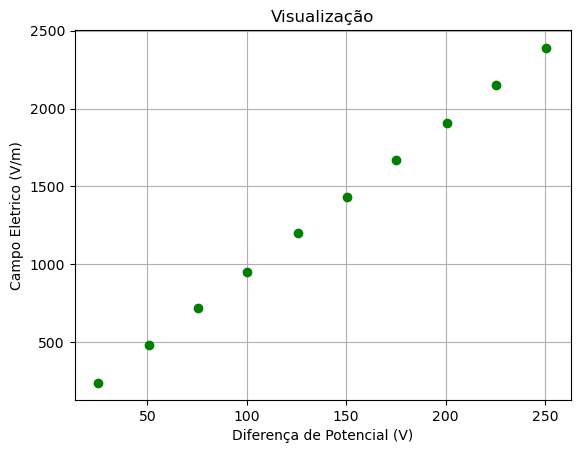

pandas.core.frame.DataFrame

In [416]:
# visualizando os dados pelo gráfico

plt.figure()
plt.errorbar(x, y, incy, incx, "og")
plt.title("Visualização")
plt.xlabel("Diferença de Potencial (V)")
plt.ylabel("Campo Eletrico (V/m)")
plt.grid()
plt.show()

type(x.to_frame())

In [417]:
# A função é linear portanto não é precisio linearizar

In [418]:
# ajustando a reta (RLS)
xlin = sm.add_constant(x)
reglin = sm.OLS(y, xlin)
reglin_dat = reglin.fit()
f_de_x = reglin_dat.params
print("coeficiente angular: ", f_de_x.iloc[0])

coeficiente angular:  -1.976002398690241


In [419]:
# transferindo incerteza de z para y
incytransf = np.sqrt(np.power(f_de_x.iloc[1] * incx, 2) + np.power(incy, 2))
incytransf

0     5.345720
1     5.920897
2     6.511019
3     7.097248
4     7.734010
5     8.347319
6     8.975609
7     9.623576
8    10.264351
9    10.919176
dtype: float64

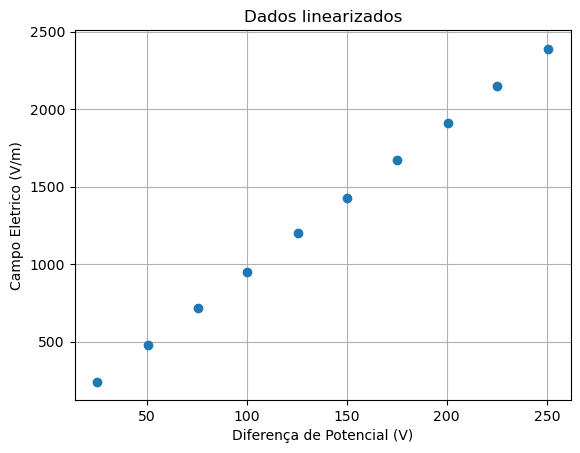

In [420]:
# visualizando os dados linearizados
plt.errorbar(x, y, incytransf, 0, "o")
plt.title("Dados linearizados")
plt.xlabel("Diferença de Potencial (V)")
plt.ylabel("Campo Eletrico (V/m)")
plt.grid()
plt.show()

In [421]:
# criando os 'pesos' a partir da incerteza
ws = 1 / (incytransf**2)
reglinw = sm.WLS(y, xlin, ws)
result_rlw = reglinw.fit()
fitpars = result_rlw.params
fiterrs = result_rlw.HC0_se
print(fitpars.iloc[0], fitpars.iloc[1])
print(fiterrs.iloc[0], fiterrs.iloc[1])

-1.9890009859398958 9.544442833945581
0.561759041771833 0.005021180646873771


In [422]:
# note que o statsmodels retorna os parâmetros em ordem inversa em relação aos outros dois métodos
p_0 = fitpars.iloc[1]  # coef ang
p_1 = fitpars.iloc[0]  # coef lin
# note que não há raiz quadrada
s_p_0 = fiterrs.iloc[1]  # incert p_0
s_p_1 = fiterrs.iloc[0]  # incert p_1
rp_0 = np.round(p_0, 2)
rp_1 = np.round(p_1, 2)
rs_p_0 = np.round(s_p_0, 2)
rs_p_1 = np.round(s_p_1, 2)
print("coef. angular=", rp_0, "+-", rs_p_0)
print("coef. linear=", rp_1, "+-", rs_p_1)

coef. angular= 9.54 +- 0.01
coef. linear= -1.99 +- 0.56


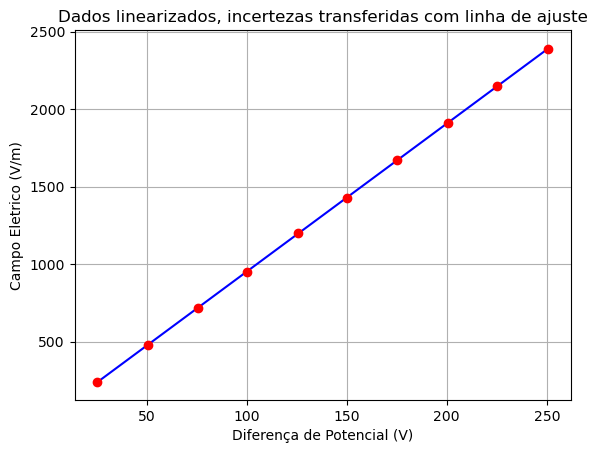

In [423]:
xline = x
yline = fitpars.iloc[0] + fitpars.iloc[1] * x
plt.errorbar(x, y, incytransf, 0, "or")
plt.title("Dados linearizados, incertezas transferidas com linha de ajuste")
plt.xlabel("Diferença de Potencial (V)")
plt.ylabel("Campo Eletrico (V/m)")
plt.plot(xline, yline, "b-")
plt.grid()
plt.show()


In [424]:
# calulando chi^2_red
invpars = fitpars.iloc[1], fitpars.iloc[0]
yhat = np.polyval(invpars, x)
chi_squared = np.sum(((yhat - y) / incytransf) ** 2)
print(chi_squared)
chi2_red = chi_squared / (len(x) - 2)
chi2_red

0.44623612590009853


np.float64(0.05577951573751232)

In [425]:
np.round(result_rlw.rsquared, 3)

np.float64(1.0)

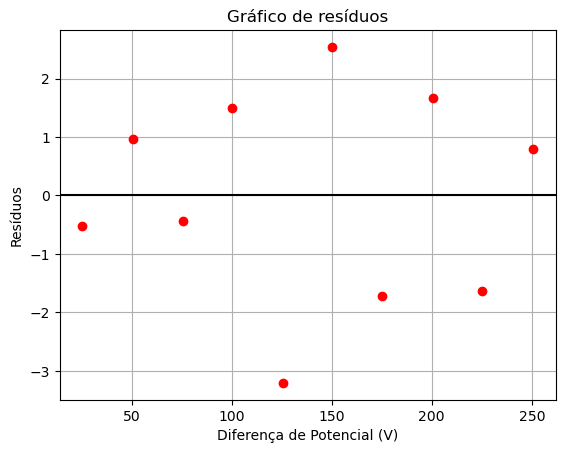

In [426]:
# Grafico de residuos
resid = yhat - y
plt.plot(x, resid, "or")
plt.title("Gráfico de resíduos")
plt.xlabel("Diferença de Potencial (V)")
plt.ylabel("Resíduos")
plt.grid()
plt.axhline(y=0, color="k", linestyle="-")

### Propagando as incertezas obtidas no ajuste

Da teoria para a analise de Campo elétrico, sabemos que a intensidade do campo elétrico uniforme é dada por:
$$ E = \frac{U}{d} $$
onde:
  - $E$ é a intensidade do campo elétrico (V/m)
  - $U$ é a tensão (V)
  - $d$ é a distância entre as placas (m)


In [427]:
# Calculando a distancia entre as placas
# A distância entre as placas é dada por d = U/E
# U = diferença de potencial
# E = campo elétrico
# a incerteza na distância é dada por
# d = U/E * sqrt((incU/U)^2 + (incE/E)^2)
# U = x
# E = y
# incU = incx
# incE = incy

a = p_0 # coef ang
s_a = s_p_0 # incerteza do coef ang
d = 1 / a
s_d = np.sqrt((s_a * (-((1/a)**2))) ** 2)

print("d = ", d , "+-", s_d)

d_med = (10.7 + 9.1 + 10.4	+ 9.9) / 4
d_med = d_med / 100

delX = 0.5
s_d_med = np.sqrt(((delX / 4) ** 2) * 4) / 100

print ("d_med = ", d_med, "+-", s_d_med)

d =  0.10477300953005023 +- 5.51194257139818e-05
d_med =  0.10024999999999999 +- 0.0025


## Tarefa 2

In [428]:
dados = pd.read_csv(
    "tarefa2.csv"
)  # Corrente(A),Torque(Nm), Incerteza Corrente(A), Incerteza Torque(Nm)
print(dados)

x = dados["dS1"] + dados["dS2"] + dados["dI1"] + dados["dI2"]
x = x / 4
y = dados["tensao (V)"] * 1000

x[0] = x[0] - 0.4
x[1] = x[1] - 0.4
x[2] = x[2] - 0.4

x = x / 100
delX = 0.5

# Incerteza para a media de 4 medições
incx = np.array([np.sqrt(((delX / 4) ** 2) * 4)] * len(x)) / 100
incy = calc_uncertainty(dados["tensao (V)"]) * 1000

for xi, incxi in zip(x, incx):
    print(f"{xi} +- {incxi}")
print("")
# Format and print y with uncertainties
for yi, incyi in zip(y, incy):
    print(f"{yi} +- {incyi}")
    


    dS1   dI1   dS2   dI2  tensao (V)  distancia (cm)
0   1.8   2.6   2.2   2.9        9.46           1.975
1   2.6   4.2   3.2   4.0        6.31           3.100
2   3.7   4.5   4.3   5.1        4.77           4.000
3   4.2   5.2   5.0   5.8        3.85           5.050
4   5.2   6.1   6.0   6.9        3.19           6.050
5   6.8   7.7   6.7   7.6        2.65           7.200
6   7.5   7.4   7.6   8.4        2.37           7.725
7   8.5   8.5   8.7   9.5        2.10           8.800
8   9.5  10.4   9.6  10.5        1.98          10.000
9  10.5  11.4  10.7  11.5        1.70          11.025
0.01975 +- 0.0025
0.031 +- 0.0025
0.04 +- 0.0025
0.050499999999999996 +- 0.0025
0.06049999999999999 +- 0.0025
0.072 +- 0.0025
0.07725 +- 0.0025
0.08800000000000001 +- 0.0025
0.1 +- 0.0025
0.11025 +- 0.0025

9460.0 +- 19.42
6310.0 +- 13.12
4770.0 +- 10.040000000000001
3850.0 +- 8.200000000000001
3190.0 +- 6.880000000000001
2650.0 +- 5.8
2370.0 +- 5.24
2100.0 +- 4.700000000000001
1980.0 +- 4.4600000000000

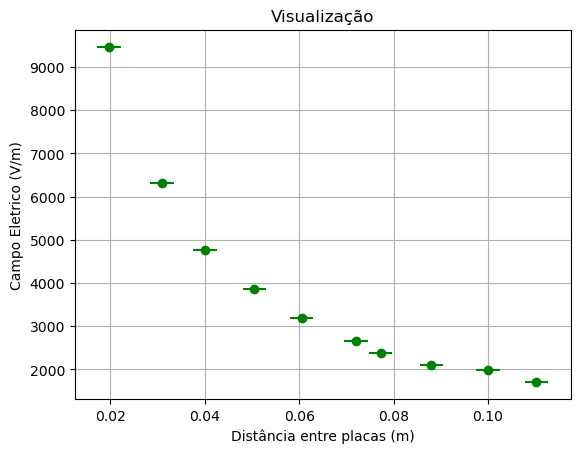

pandas.core.frame.DataFrame

In [429]:
# visualizando os dados pelo gráfico

plt.figure()
plt.errorbar(x, y, incy, incx, "og")
plt.title("Visualização")
plt.xlabel("Distância entre placas (m)")
plt.ylabel("Campo Eletrico (V/m)")
plt.grid()
plt.show()

type(x.to_frame())

In [430]:
# A funçao é do tipo E = U/d
# Linearizando temos que z = 1/x
z = 1/x
z

0    50.632911
1    32.258065
2    25.000000
3    19.801980
4    16.528926
5    13.888889
6    12.944984
7    11.363636
8    10.000000
9     9.070295
dtype: float64

In [431]:
#propagando a incerteza por conta da linearização
sigma_z = incx/np.power(x,2)
sigma_z

0    6.409229
1    2.601457
2    1.562500
3    0.980296
4    0.683013
5    0.482253
6    0.418932
7    0.322831
8    0.250000
9    0.205676
dtype: float64

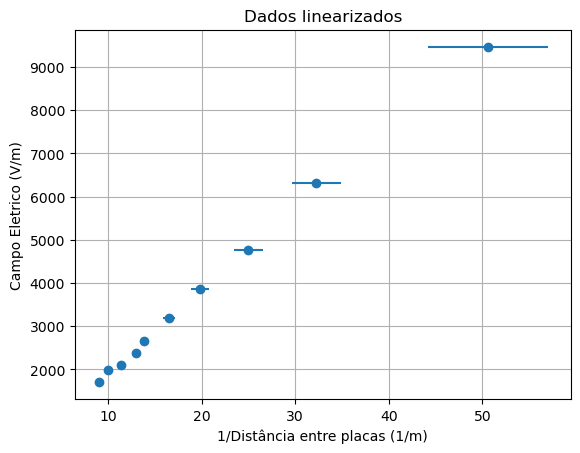

In [432]:
# visualizando os dados linearizados
plt.errorbar(z, y, incy,sigma_z,'o')
plt.title("Dados linearizados")
plt.xlabel("1/Distância entre placas (1/m)")
plt.ylabel("Campo Eletrico (V/m)")
plt.grid()
plt.show()

In [433]:
#ajustando a reta (RLS)
xlin = sm.add_constant(z)
reglin = sm.OLS(y,xlin)
reglin_dat = reglin.fit()
f_de_z = reglin_dat.params
print("coeficiente angular: ", f_de_z.iloc[0])

coeficiente angular:  39.98466093305217


In [434]:
#transferindo incerteza de z para y
incytransf = np.sqrt(np.power(f_de_z.iloc[1]*sigma_z,2)+np.power(incy,2)) 
incytransf

0    1208.275045
1     490.541672
2     294.697267
3     184.964486
4     128.929523
5      91.087990
6      79.140898
7      61.033753
8      47.334775
9      38.964855
dtype: float64

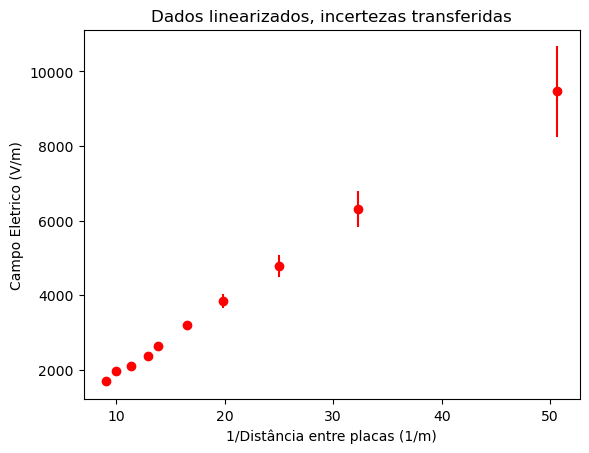

In [435]:
#plotando gráfico com as incertezas transferidas para a variável dependente (y)
plt.errorbar(z, y, incytransf,0,'or')
plt.title("Dados linearizados, incertezas transferidas")
plt.xlabel("1/Distância entre placas (1/m)")
plt.ylabel("Campo Eletrico (V/m)")
plt.show()

In [436]:
#criando os 'pesos' a partir da incerteza
ws = 1/(incytransf**2)
reglinw = sm.WLS(y,xlin,ws)
result_rlw = reglinw.fit()
fitpars = result_rlw.params
fiterrs = result_rlw.HC0_se
print(fitpars.iloc[0],fitpars.iloc[1])
print(fiterrs.iloc[0],fiterrs.iloc[1])

-15.433826025040162 191.30156805114262
61.05119966750802 4.29074246582002


In [437]:
#note que o statsmodels retorna os parâmetros em ordem inversa em relação aos outros dois métodos
p_0 = fitpars.iloc[1] #coef ang
p_1 = fitpars.iloc[0] #coef lin
#note que não há raiz quadrada
s_p_0 = fiterrs.iloc[1] #incert p_0
s_p_1 = fiterrs.iloc[0] #incert p_1
rp_0 = np.round(p_0,2)
rp_1 = np.round(p_1,2)
rs_p_0 = np.round(s_p_0,2)
rs_p_1 = np.round(s_p_1,2)
print("coef. angular=",rp_0,"+-",rs_p_0)
print("coef. linear=",rp_1,"+-",rs_p_1)

coef. angular= 191.3 +- 4.29
coef. linear= -15.43 +- 61.05


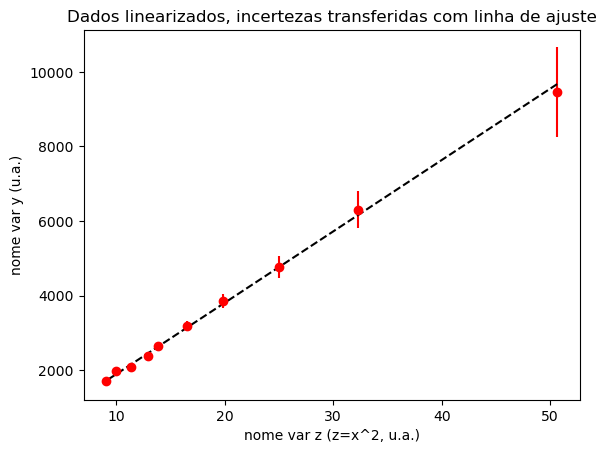

In [438]:
xline = z
yline = fitpars.iloc[0] + fitpars.iloc[1] * z
plt.errorbar(z, y, incytransf,0,'or')
plt.title("Dados linearizados, incertezas transferidas com linha de ajuste")
plt.xlabel("nome var z (z=x^2, u.a.)")
plt.ylabel("nome var y (u.a.)")
#incluindo a linha do ajuste linear, k=preto, '--' = linha tracejada
plt.plot(xline, yline, 'k--')

In [439]:
#calulando chi^2_red
invpars = fitpars.iloc[1],fitpars.iloc[0]
yhat = np.polyval(invpars, z)
chi_squared = np.sum(((yhat - y)/incytransf) ** 2)
print(chi_squared)
chi2_red = chi_squared/(len(z)-2)
chi2_red

5.9523879377995845


np.float64(0.7440484922249481)

In [440]:
np.round(result_rlw.rsquared,3)

np.float64(0.988)

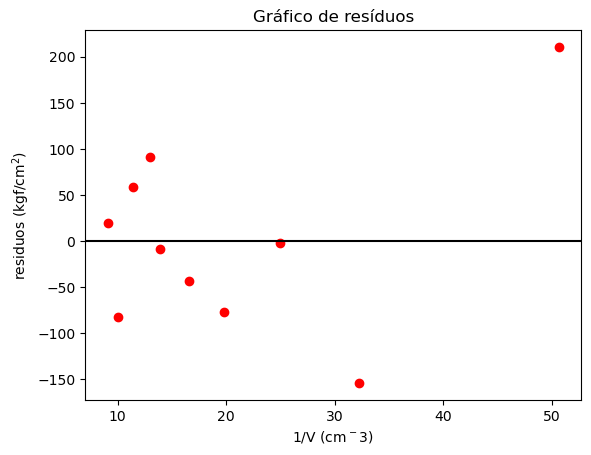

In [441]:
resid = (yhat - y)
plt.plot(z, resid, 'or')
plt.title("Gráfico de resíduos")
plt.xlabel("1/V (cm$^-3$)")
plt.ylabel("residuos (kgf/cm$^2$)")
plt.axhline(y=0, color='k', linestyle='-')

### Propagando as incertezas obtidas no ajuste

Da teoria para a analise de Campo elétrico, sabemos que a intensidade do campo elétrico uniforme é dada por:
$$ E = \frac{U}{d} $$
onde:
  - $E$ é a intensidade do campo elétrico (V/m)
  - $U$ é a tensão (V)
  - $d$ é a distância entre as placas (m)


In [443]:
# Calculando a tensão entre as placas
# O campo elétrico é dado por E = U/d
# isolando z = 1/d temos que coef. angular = U

a = p_0 # coef ang
s_a = s_p_0 # incerteza do coef ang
U = a
s_u = s_a

print("U = ", U , "+-", s_u)

U_med = 200.7
s_U_med = calc_uncertainty(U_med, decimal_places=1)

print("U_med = ", U_med, "+-", s_U_med)

U =  191.30156805114262 +- 4.29074246582002
U_med =  200.7 +- 0.9014


Encontramos na primeira tarefa uma distancia de d =  0.10477 +- 6e-05 m e na segunda tarefa uma tensão de U =  191 +- 4 V, que são muito proximos dos valores medidos de d_med =  0.100 +- 0.003 e U_med =  200.7 +- 0.9